# LLM .pcap analysis


### High Level Architecture:


1. PCAP file

      ↓


2. Packet Parser (Scapy / PyShark)

      ↓


3. Feature Extraction

      ↓


4. Packet Summaries (text)

      ↓


5. Local LLM (Ollama / llama.cpp / GPT4All)

      ↓


6. Attack Classification + Explanation

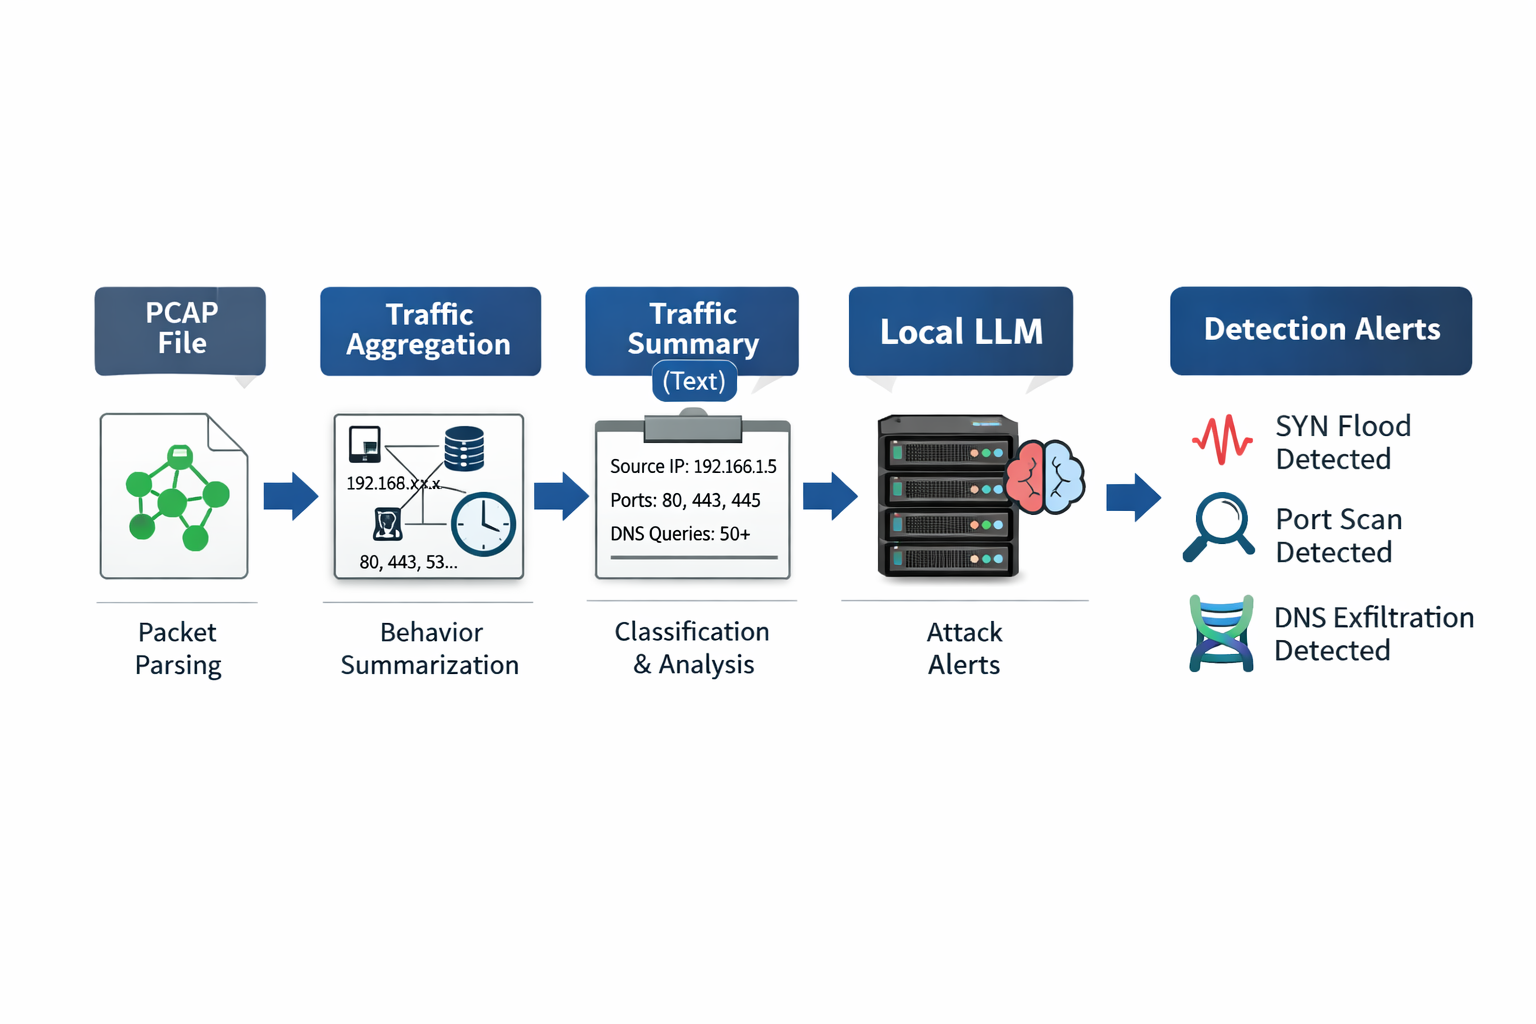

In [29]:
from IPython.display import Image, display
import numpy as np  

display(Image(filename="image/system_architecture.png"))


In [43]:
from scapy.all import rdpcap, IP, TCP, DNS
from collections import defaultdict
import subprocess

def load_pcap(path, max_packets=None):
    packets = rdpcap(path)
    if max_packets is not None and max_packets > 0:
        return packets[:max_packets]
    return packets


### Security Feature Extraction

In [31]:
# SYN Flood Aggregation
def aggregate_syn_flood(packets):
    flows = defaultdict(lambda: {
        "syn": 0,
        "ack": 0,
        "start": None,
        "end": None
    })

    for pkt in packets:
        if pkt.haslayer(IP) and pkt.haslayer(TCP):
            ip, tcp = pkt[IP], pkt[TCP]
            key = (ip.src, ip.dst)

            flows[key]["start"] = flows[key]["start"] or pkt.time
            flows[key]["end"] = pkt.time

            if tcp.flags == "S":
                flows[key]["syn"] += 1
            if "A" in str(tcp.flags):
                flows[key]["ack"] += 1

    return flows

# Port scan aggregation
def aggregate_port_scan(packets):
    scans = defaultdict(lambda: {
        "ports": set(),
        "timestamps": []
    })

    for pkt in packets:
        if pkt.haslayer(IP) and pkt.haslayer(TCP):
            ip, tcp = pkt[IP], pkt[TCP]
            scans[ip.src]["ports"].add(tcp.dport)
            scans[ip.src]["timestamps"].append(pkt.time)

    return scans

# DNS Exfiltration Aggregation
def aggregate_dns_exfiltration(packets):
    dns_data = defaultdict(list)

    for pkt in packets:
        if pkt.haslayer(IP) and pkt.haslayer(DNS):
            dns = pkt[DNS]
            if dns.qr == 0:  # query
                src_ip = pkt[IP].src
                qname = dns.qd.qname.decode(errors="ignore")
                dns_data[src_ip].append((pkt.time, qname))

    return dns_data





### Summarizing

In [37]:
def syn_flood_summary(src, dst, data):
    duration = data["end"] - data["start"]
    return f"""
Source IP: {src}
Destination IP: {dst}
Duration: {duration:.2f} seconds
TCP SYN count: {data['syn']}
TCP ACK count: {data['ack']}
"""

def port_scan_summary(src, data):
    # Safely compute average timestamp activity; handle empty or non-numeric values
    timestamps = data.get('timestamps', [])
    if len(timestamps) == 0:
        avg_activity = 0.0
    else:
        try:
            arr = np.array([float(t) for t in timestamps], dtype=float)
            avg_activity = float(arr.mean())
        except Exception:
            try:
                avg_activity = float(np.mean(list(map(float, timestamps))))
            except Exception:
                avg_activity = 0.0
    ports_sample = sorted(list(data.get('ports', set())))[:10]
    return f"""
Source IP: {src}
Unique destination ports: {len(data.get('ports', []))}
Ports contacted (sample): {ports_sample}
Average of activity (sample): {avg_activity:.2f} seconds
"""

def dns_exfiltration_summary(src, queries, threshold=50):
    long_q = [q for _, q in queries if len(q) > threshold]
    return f"""
Source IP: {src}
Total DNS queries: {len(queries)}
Long DNS queries: {len(long_q)}
Example long queries: {long_q[:3]}
Total time elapsed: {queries[-1][0] - queries[0][0]:.2f} seconds`
"""


### Prompting

In [33]:
SYSTEM_PROMPT = """
You are a network intrusion detection system.

Classify the traffic as:
- SYN Flood
- Port Scan
- DNS Exfiltration
- Benign

Respond ONLY in JSON:
{
  "attack": "<type>",
  "suspicious": true/false,
  "confidence": 0-100,
  "reasoning": "<short explanation>"
}
"""



In [ ]:
import subprocess
import json

# Simple in-memory cache to avoid repeated slow subprocess LLM calls
_llm_cache = {}

# Call LLM for analysis (with caching and optional bypass)
def llm_classify(packet_text, use_llm=True, timeout=10):
    key = packet_text
    if key in _llm_cache:
        return _llm_cache[key]

    if not use_llm:
        # Fast heuristic-based fallback for lab/testing to avoid calling the external LLM
        lower = packet_text.lower()
        if "tcp syn count" in lower or "syn" in lower and "ack" in lower:
            attack = "SYN Flood"
            suspicious = True
            confidence = 80
            reasoning = "High SYN/ACK imbalance detected (heuristic)"
        elif "unique destination ports" in lower or "ports contacted" in lower:
            attack = "Port Scan"
            suspicious = True
            confidence = 70
            reasoning = "Many unique destination ports contacted (heuristic)"
        elif "dns" in lower and ("long dns queries" in lower or "long_q" in lower):
            attack = "DNS Exfiltration"
            suspicious = True
            confidence = 75
            reasoning = "Long or frequent DNS queries observed (heuristic)"
        else:
            attack = "Benign"
            suspicious = False
            confidence = 30
            reasoning = "No strong heuristic indicators"

        out = json.dumps({
            "attack": attack,
            "suspicious": suspicious,
            "confidence": confidence,
            "reasoning": reasoning
        })
        _llm_cache[key] = out
        return out

    try:
        result = subprocess.run(
            ["ollama", "run", "mistral"],
            input=SYSTEM_PROMPT + "\n\n" + packet_text,
            text=True,
            capture_output=True,
            timeout=timeout
        )
        out = result.stdout.strip() or result.stderr.strip()
        if not out:
            out = json.dumps({"attack": "Unknown", "suspicious": False, "confidence": 0, "reasoning": "empty LLM response"})
    except subprocess.TimeoutExpired:
        out = json.dumps({"attack": "Unknown", "suspicious": False, "confidence": 0, "reasoning": "LLM timeout"})
    except Exception as e:
        out = json.dumps({"attack": "Error", "suspicious": False, "confidence": 0, "reasoning": str(e)})

    _llm_cache[key] = out
    return out


In [ ]:
def detect_attacks(packets, use_llm=True):
    results = []

    syn_flows = aggregate_syn_flood(packets)
    for (src, dst), data in syn_flows.items():
        summary = syn_flood_summary(src, dst, data)
        results.append(llm_classify(summary, use_llm=use_llm))

    port_scans = aggregate_port_scan(packets)
    for src, data in port_scans.items():
        summary = port_scan_summary(src, data)
        results.append(llm_classify(summary, use_llm=use_llm))

    dns_flows = aggregate_dns_exfiltration(packets)
    for src, queries in dns_flows.items():
        summary = dns_exfiltration_summary(src, queries)
        results.append(llm_classify(summary, use_llm=use_llm))

    return results


In [39]:
packets = load_pcap("pcap/DNS_minim.pcap")
alerts = detect_attacks(packets)

for alert in alerts:
    print(alert)
    print("=" * 60)


 {
  "attack": "Possible DNS Exfiltration",
  "suspicious": true,
  "confidence": 75,
  "reasoning": "Excessive DNS queries (51) and long DNS queries (32) were observed from the source IP within a short period of time (12.61 seconds). The long DNS queries contain multiple sub-domains of iodine-cname.com, which is indicative of data exfiltration."
}


 {
  "attack": "Possible DNS Amplification",
  "suspicious": true,
  "confidence": 85,
  "reasoning": "High volume of DNS queries (50) from a single source IP within a short time span (4.99 seconds), which is indicative of a potential DNS amplification attack."
}


 {
  "attack": "Suspicious Activity",
  "suspicious": true,
  "confidence": 70,
  "reasoning": "Large number of DNS queries (50) within a short period (1.25 seconds), with one long query ('init.ORSXQ5BOOR4HI7BVHA2DEMI.base32.api.daumel.xyz.'). This behavior may indicate a potential DNS Exfiltration attempt."
}




In [ ]:
packets = load_pcap("pcap/SYNflood.pcap",200)
alerts = detect_attacks(packets)

for alert in alerts:
    print(alert)
    print("=" * 60)


In [ ]:
packets = load_pcap("pcap/PortScan.pcap")
alerts = detect_attacks(packets)

for alert in alerts:
    print(alert)
    print("=" * 60)


 {
  "attack": "Possible SYN Flood",
  "suspicious": true,
  "confidence": 70,
  "reasoning": "The traffic duration of 8 seconds with a high number of SYN packets (2) and no ACK packets indicates a potential SYN Flood attack."
}


 {
  "attack": "SYN Flood",
  "suspicious": true,
  "confidence": 80,
  "reasoning": "High number of SYN packets (9) compared to ACK packets (114), which is a common characteristic of SYN Flood attacks."
}


 {
  "attack": "Port Scan",
  "suspicious": true,
  "confidence": 80,
  "reasoning": "High volume of TCP ACK packets without initial SYN packets is indicative of a port scan attack."
}


 {
  "attack": "SYN Flood",
  "suspicious": true,
  "confidence": 95,
  "reasoning": "The high number of unanswered SYN packets (15) within a short duration (19.58 seconds) suggests a SYN Flood attack."
}


 {
  "attack": "SYN Flood",
  "suspicious": true,
  "confidence": 95,
  "reasoning": "A single TCP SYN packet received without a matching TCP ACK in response suggests 